# APOGEE-FIRE on SPARK: orbital eccentricities

As an example of a non-trivial workload that can take advantage of the distribution of arbitrary code to rows of a large dataset - combined with SQL expressions - we compute orbital eccentricity for a population of stars and compare distributions for different metallicities.

For this example we deploy galpy orbital integration to a subset of the full catalog and then aggregate to generate a histogram accumulating object counts in two regimes of iron abundance. 

### Configure the spark session
At startup time, we can tell spark of any requirements we have on amount of memory or other settings. In this case 5 concurrent tasks run under the same process and share 8gb of memory - any number of these units will be run in parallel across the cluster as needed. We also set the HOME directory, as galpy will create a configuration file on startup - but in the cluster we do not have a concept of persistent home directory.

In [1]:
%%configure -f
{ "executorMemory": "8g", "executorCores": 5, 
  "conf": { 
      "spark.sql.files.maxPartitionBytes": 268435456,
      "spark.executorEnv.HOME": "/tmp",
      "spark.yarn.appMasterEnv.HOME": "/tmp"
  }
}

Another galpy related settings, ensuring we override the home environment on the driver program, which runs alongside workers managing them. Since this is the first code cell, it triggers the creation of a spark session on the remote cluster.

In [2]:
import os
os.environ['HOME'] = '/tmp'

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
92,application_1652993163904_0093,pyspark,idle,Link,Link,arik,✔


SparkSession available as 'spark'.


In [3]:
import pandas as pd
import numpy as np
import healpy as hp
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from matplotlib import pyplot as plt
from astropy import units

### Setup code for distribution

There are a number of ways to distribute python code in Spark. Here we use the [mapInPandas](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.mapInPandas.html) function of the Spark DataFrame, which takes as input pandas dataframes and produces pandas dataframes as output. We've separated the core functionality of computing the results into a dataframe, with the glue that `mapInPandas` expects (an iterator of dataframes, plus the output schema)

In [4]:
def get_orbits(df):
    o = Orbit(df[['ra','dec','dhel','pmra','pmdec','radial_velocity']].values, radec=True)
    lb = np.linspace(0, 10, 1000)
    o.integrate(lb, MWPotential2014, method='rk4_c')
    r_df = pd.DataFrame({'e': o.e(), 'feh': df['feh_apogee'].values})
    return r_df

def get_orbits_mapper():
    def mapper(it):
        for df in it:
            yield get_orbits(df)
    schema = 'e double, feh double'
    return mapper, schema

### Deploy

First downsample and select the columns of interest. The underlying data are stored in [parquet](https://parquet.apache.org/) format, which is a column-oriented store - meaning that the fewer columns we require, the less data we have to load. For the purpose of orbit integration, we will require that radial_velocities be numbers (in this case, the others are also valid), and we filter out the most extreme low-metallicity stars.

The SQL query will return a DataFrame, which we then sample (to enable the query to run in interactive-ish-time) and deploy the galpy integration code as defined above.

Finally, we register the output DataFrame as a temporary table so we can reference it in SQL statements. 

In [5]:
integrated = spark.sql('''
SELECT ra,dec,dhel_obs as dhel,pmra,pmdec,radial_velocity,l,b,feh_apogee
FROM apogee_fire.m12f_lsr0
WHERE
  feh_apogee > -2 AND NOT isnan(radial_velocity) AND NOT isnan(feh_apogee)
'''
).sample(0.1).mapInPandas(*get_orbits_mapper())
integrated.createOrReplaceTempView('integrated')

You might note that the above cell executes very quickly! This is because Spark is a lazy execution system. Until we actually ask for results (e.g. by counting, displaying part of the table, collected the whole output, etc.) all spark does is record the required operations in a graph. This enables optimization opportunities in case things like filters get applied by later queries that can be pushed down the graph.

In the below query, we generate the final histogram, creating bins in eccentricity at a resolution of 0.01, accumulating stellar counts for case of "low metallicity" ([Fe/H] <= -1) and "high metallicity" ([Fe/H] > -1).

In this case, the `toPandas` collects all results as a pandas dataframe, and thus triggers the execution of the entire graph up to and including this query. Because we've binned and grouped (and because we know e will be between 0 and 1), the result set is limited and feasible to download from the cluster to the drivers memory (if not, it will surely crash the session!)

In [6]:
eh = spark.sql('''
SELECT e, sum(lm) as lm, sum(hm) as hm
FROM (
  SELECT FLOOR(e * 100)/100 as e, CASE WHEN feh <= -1 THEN 1 ELSE 0 END AS lm, CASE WHEN feh > -1 THEN 1 ELSE 0 END AS hm
  FROM integrated
)
GROUP BY e
ORDER BY e
''').toPandas()

While waiting (on our current cluster - roughly 10 minutes for this query), you can have a look at the spark history UI, which shows details on the operations being performed on the cluster and tracks progress. You can view detailed query plans and the graphs that make up computations sent to the cluster. Unfortunately, since it is primarily meant for viewing the status of batch jobs, it can be slow to load and may have delays to update infromation. Click in the <span style="color:blue">[HIST]</span> link above.

Just to demonstrate how many objects we have integrated, look at total counts in each group:

In [7]:
eh[['lm','hm']].sum()

lm     202335
hm    4960447
dtype: int64

### Plot

Finally we can plot the result!

In [8]:
plt.clf()
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.fill_between(eh['e'], eh['lm'] / eh['lm'].sum(), step='pre', alpha=0.2)
plt.step(eh['e'], eh['lm'] / eh['lm'].sum(), label='[Fe/H] <= -1')
plt.fill_between(eh['e'], eh['hm'] / eh['hm'].sum(), step='pre', alpha=0.2)
plt.step(eh['e'], eh['hm'] / eh['hm'].sum(), label='[Fe/H] > -1')
plt.gca().tick_params(direction='in', which='both')
plt.xlabel('e')
plt.ylabel('P')
plt.title('Orbital eccentricity by metallicity')
plt.legend()

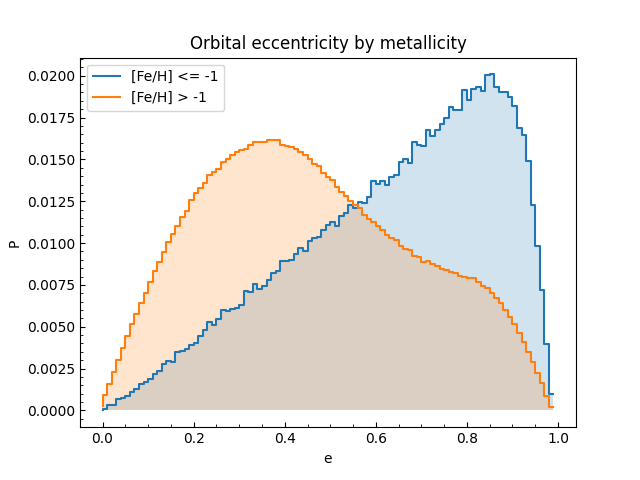

In [9]:
%matplot plt

Up until now, all code cells were sent off to the spark driver for execution by the underlying [sparkmagic](https://github.com/jupyter-incubator/sparkmagic) kernel. This means we have no access to the filesystems mounted on our container and thus can't save output objects for use in SciServer outside this environment.

While sparkmagic has some built-in ways to get data from the cluster to the local environment - it only supports doing so for spark dataframes at the moment. If we don't want to have to re-execute the entire query, here is a little trick to get the pandas dataframe from the cluster. After this, we can save it to a SciServer user volume. We may design some magics or other functionality for loading results from the cluster directly to SciServer via the api for convenience (and for larger data).

the `%%local` cell-magic does all operations locally (and note that any imports we did above were on the cluster, so we need to set up the local environment)

In [20]:
%%capture ehcsv
%%spark
print(eh.to_csv(index=False))

In [23]:
%%local
import pandas as pd
from io import StringIO
eh = pd.read_csv(StringIO(ehcsv.stdout)).set_index('e')
print(eh.head())

       lm     hm
e               
0.00    4   1413
0.01   16   4555
0.02   63   7954
0.03   67  11427
0.04  135  14894


In [24]:
%%local
eh.to_csv('apogee_fire_eccentricity_distributions.csv')

this magic is also done locally

In [27]:
%ls -lh apogee_fire*.csv

-rw-rw-r--. 1 idies idies 1.6K Jun 10 21:15 apogee_fire_eccentricity_distributions.csv
